# 01 — Explore ShapeNetCore

Use this notebook with the **Python (pytorch3d)** kernel.

In [1]:
# If the kernel isn't set yet: Kernel → Change Kernel → Python (pytorch3d)
import sys, os, platform, torch
print("Python:", sys.version)
print("PyTorch:", torch.__version__, " MPS avail:", torch.backends.mps.is_available())


Python: 3.10.18 (main, Jun  5 2025, 08:37:47) [Clang 14.0.6 ]
PyTorch: 2.8.0  MPS avail: True


## Paths
Set this to your local dataset path. For this project it's expected at `./shapeNetCore`. Adjust if yours differs.

In [2]:
from pathlib import Path
SHAPENET_PATH = Path('../data/shapeNetCore').expanduser().resolve()
assert SHAPENET_PATH.exists(), f"ShapeNetCore folder not found at {SHAPENET_PATH}"
print("Using SHAPENET_PATH:", SHAPENET_PATH)

Using SHAPENET_PATH: /Users/brageramberg/Desktop/3DCNN/data/shapeNetCore


## Imports

In [3]:
import sys, os, importlib.util, pathlib
print("Python:", sys.executable)
print("First few sys.path entries:", sys.path[:5])

# Is there a local matplotlib module/folder?
candidates = []
for base in [pathlib.Path('.'), pathlib.Path('..')]:
    for name in ["matplotlib.py", "matplotlib"]:
        p = base / name
        if p.exists():
            candidates.append(p.resolve())
print("Local candidates:", candidates)

# Where would Python import matplotlib from?
spec = importlib.util.find_spec("matplotlib")
print("Import spec for matplotlib:", spec)

Python: /Users/brageramberg/opt/miniconda3/envs/pytorch3d/bin/python
First few sys.path entries: ['/Users/brageramberg/opt/miniconda3/envs/pytorch3d/lib/python310.zip', '/Users/brageramberg/opt/miniconda3/envs/pytorch3d/lib/python3.10', '/Users/brageramberg/opt/miniconda3/envs/pytorch3d/lib/python3.10/lib-dynload', '', '/Users/brageramberg/opt/miniconda3/envs/pytorch3d/lib/python3.10/site-packages']
Local candidates: []
Import spec for matplotlib: ModuleSpec(name='matplotlib', loader=<_frozen_importlib_external.SourceFileLoader object at 0x127757eb0>, origin='/Users/brageramberg/opt/miniconda3/envs/pytorch3d/lib/python3.10/site-packages/matplotlib/__init__.py', submodule_search_locations=['/Users/brageramberg/opt/miniconda3/envs/pytorch3d/lib/python3.10/site-packages/matplotlib'])


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from pytorch3d.datasets import ShapeNetCore, collate_batched_meshes
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, PointLights, RasterizationSettings, look_at_view_transform
)
from pytorch3d.structures import Meshes
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

Device: mps


## Load dataset and Category overview

In [5]:
from pytorch3d.datasets import ShapeNetCore
import os
from pathlib import Path

synset = SHAPENET_PATH / "03211117"
print("Synset exists:", synset.exists())
print("Contents of synset:", os.listdir(synset)[:5])

shapenet_dataset = ShapeNetCore(str(SHAPENET_PATH), version=2, load_textures=False)
print("Total models:", len(shapenet_dataset))


Synset exists: True
Contents of synset: ['91db88d4d0956e92a9a12c50dc330a66', 'eb2b450565c77e3efc7ff8f848d1c6c9', '871dcd6740ed8d2891a7ac029a825f73', 'aa73f1b28817376c6cf19e722198d69', '4516c31dae48a0efbff4c0ca0d98b77']
Total models: 3891


/Users/brageramberg/opt/miniconda3/envs/pytorch3d/lib/python3.10/site-packages/pytorch3d/datasets/shapenet/shapenet_core.py:116: UserWarning: The following categories are included in ShapeNetCore ver.2's official mapping but not found in the dataset location /Users/brageramberg/Desktop/3DCNN/data/shapeNetCore: 03991062, 04468005, 03691459, 02843684, 04225987, 02880940, 02691156, 03624134, 04460130, 02818832, 03938244, 04530566, 02871439, 02828884, 03593526, 04554684, 03797390, 03710193, 03790512, 03948459, 02773838, 03636649, 04379243, 04074963, 04090263, 02958343, 04099429, 03085013, 03325088, 02954340, 04330267, 04401088, 03928116, 02747177, 02876657, 02946921, 04004475, 02933112, 03759954, 03761084, 03513137, 03337140, 03207941, 03261776, 02924116, 03467517, 03001627, 04256520, 02801938, 02942699
  warnings.warn(msg)


In [6]:
#look at one sample

sample = shapenet_dataset[0]
print("Keys:", sample.keys())
print("Synset:", sample["synset_id"])
print("Model ID:", sample["model_id"])
print("Verts:", sample["verts"].shape, "Faces:", sample["faces"].shape)

Keys: dict_keys(['synset_id', 'model_id', 'verts', 'faces', 'textures', 'label'])
Synset: 02992529
Model ID: 49a51e66314253d3f2a0433fb7c53e0f
Verts: torch.Size([1772, 3]) Faces: torch.Size([7024, 3])


In [7]:
from collections import Counter

cat_counts = Counter()
for i in range(len(shapenet_dataset)):
    try:
        cat_counts[shapenet_dataset[i]["synset_id"]] += 1
    except Exception as e:
        # skip broken model
        print("Some model is broken")
        continue

print("Categories found:", len(cat_counts))
print("Example:", list(cat_counts.items())[:10])

Categories found: 5
Example: [('02992529', 831), ('02808440', 856), ('03211117', 1093), ('03642806', 460), ('03046257', 651)]


In [11]:
SYNSET_ID_TO_NAME = {
    "02691156": "airplane",
    "02773838": "bag",
    "02801938": "basket",
    "02808440": "bathtub",
    "02818832": "bed",
    "02828884": "bench",
    "02876657": "bottle",
    "02880940": "bowl",
    "02924116": "bus",
    "02933112": "cabinet",
    "02958343": "car",
    "03001627": "chair",
    "03211117": "monitor",
    "03636649": "lamp",
    "03642806": "laptop",
    "03797390": "mug",
    "04004475": "printer",
    "04256520": "sofa",
    "04379243": "table",
    "04530566": "vessel",
    # ... add more if needed
}

In [12]:
import pandas as pd

rows = []
for synset, count in sorted(cat_counts.items(), key=lambda x: -x[1]):
    rows.append({
        "synset_id": synset,
        "name": SYNSET_ID_TO_NAME.get(synset, "unknown"),
        "count": count
    })

df_cats = pd.DataFrame(rows)
print("Total categories:", len(df_cats))
df_cats.head(15)

Total categories: 5


,synset_id,name,count
0,03211117,monitor,1093
1,02808440,bathtub,856
2,02992529,unknown,831
3,03046257,unknown,651
4,03642806,laptop,460


In [13]:
import json
from importlib import resources
from pytorch3d.datasets import shapenet as p3d_shapenet

# Load the synset->name map that ships with PyTorch3D (v2 here)
with resources.files(p3d_shapenet).joinpath("shapenet_synset_dict_v2.json").open("r") as f:
    synset_map_v2 = json.load(f)  # e.g. {"03001627": "chair", ...}

# Rebuild your dataframe with proper names
import pandas as pd
from collections import Counter

cat_counts = Counter([shapenet_dataset._get_item_ids(i)["synset_id"] for i in range(len(shapenet_dataset))])

rows = []
for synset, count in sorted(cat_counts.items(), key=lambda x: -x[1]):
    rows.append({
        "synset_id": synset,
        "name": synset_map_v2.get(synset, "unknown"),
        "count": count
    })

df_cats = pd.DataFrame(rows)
print("Total categories:", len(df_cats))
df_cats.head(20)

Total categories: 5


,synset_id,name,count
0,03211117,display,1093
1,02808440,bathtub,856
2,02992529,cellphone,831
3,03046257,clock,651
4,03642806,laptop,460


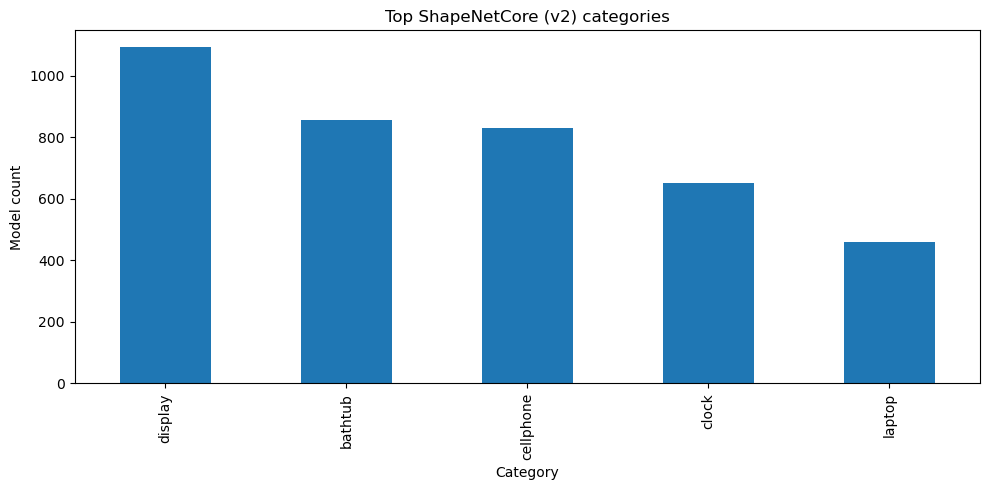

In [18]:
# Top 10 categories by count
df_cats.sort_values("count", ascending=False).head(10)

# Any synsets without a name (should be none now)
df_cats[df_cats["name"] == "unknown"]

# Plot distribution (requires matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(df_cats.sort_values("count", ascending=False)
        .head(15)
        .set_index("name")["count"]
        .plot(kind="bar"))
plt.title("Top ShapeNetCore (v2) categories")
plt.xlabel("Category")
plt.ylabel("Model count")
plt.tight_layout()
plt.show()